
# Weather-Aware Routing – Preprocessing, Scoring, and ML Model

This notebook:
1. Loads the combined dataset.
2. Preprocesses the data (cleaning, encoding, missing values).
3. Implements **Weather Sensitivity Scoring Logic**.
4. Performs basic EDA.
5. Trains and evaluates a Machine Learning model.


In [8]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("Combined_Weather_Traffic_EV.csv")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (300, 57)


,InfrastructureID,RatePerHour,MaxTime,Latitude,Longitude,TAVG,PRCP,TMAX,TMIN,OBJECTID,...,TMIN_ATTRIBUTES,OBJECTID.2,OBJECTID.3,Label,Direction,SHAPE_Length,Year,PDF,geometry.2,geometry.3
0,PSP002216,Regular parking fees apply.,NaN,48.424600,-123.361093,26.3,0.0,38.4,18.2,19,...,",,a",19,1,450(92),both,8.000000,1992,NaN,POINT (-123.3638054044696 48.42511956618813),LINESTRING (-123.33190031062234 48.40990115042...
1,PSP002223,Free,NaN,48.446989,-123.334368,20.9,0.0,32.6,19.9,197,...,",,a",197,2,650(92),both,8.000040,1992,NaN,POINT (-123.33506163541432 48.44690464482426),LINESTRING (-123.33121562693142 48.41416665664...
2,PSP002225,Free,NaN,48.442372,-123.331238,17.3,0.0,21.8,15.3,430,...,",,a",430,3,370(87),both,7.999972,1987,NaN,POINT (-123.33499999346992 48.44683484227543),LINESTRING (-123.34398075493085 48.41359584867...
3,PSP000511,$3.00,90 MIN,48.422837,-123.367715,19.6,0.0,22.9,14.5,529,...,",,a",529,4,450(87),both,7.999988,1987,NaN,POINT (-123.36636785301413 48.425932381530174),LINESTRING (-123.34505607281409 48.41407090763...
4,PSP000629,$3.00,40 MIN,48.429492,-123.368619,22.2,0.0,30.1,15.8,778,...,",,a",778,5,280(87),both,7.999996,1987,NaN,POINT (-123.36964991148943 48.42796548598136),LINESTRING (-123.34501165382068 48.41496048523...


In [9]:
df = df.copy()  # make sure we're working on a real copy

num_cols = ['TMAX', 'TMIN', 'PRCP', 'Temp_Range']
for col in num_cols:
    if col in df.columns:
        # ensure numeric then fill
        s = pd.to_numeric(df[col], errors='coerce')
        df[col] = s.fillna(s.mean())

# Encode categorical variables (deterministic)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category').cat.codes

In [10]:
# --- Scoring logic 

# 1) Ensure required columns exist and are numeric
for c in ["TMAX", "TMIN", "PRCP"]:
    if c not in df.columns:
        df[c] = 0
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(df[c].astype(float).mean())

# 2) Ensure Temp_Range exists
if "Temp_Range" not in df.columns:
    df["Temp_Range"] = df["TMAX"] - df["TMIN"]
df["Temp_Range"] = pd.to_numeric(df["Temp_Range"], errors="coerce").fillna(0)

# 3) Flags
df["High_Temp_Flag"] = (df["TMAX"] > 35).astype(int)
df["Low_Temp_Flag"]  = (df["TMIN"] < 5).astype(int)
df["No_Precip_Flag"] = (df["PRCP"] == 0).astype(int)

# 4) Temp range score (CREATE the column!)
def temp_range_score(x):
    if x > 20: return 1.0
    if x < 10: return 0.0
    return 0.5

df["Temp_Range_Score"] = df["Temp_Range"].apply(temp_range_score)

# 5) Final score
df["Weather_Sensitivity_Score"] = (
    2.0 * df["High_Temp_Flag"]
  + 1.5 * df["Low_Temp_Flag"]
  + 1.0 * (1 - df["No_Precip_Flag"])
  + df["Temp_Range_Score"]
)

# Optional: normalize to 0–1
df["Weather_Sensitivity_Score_Norm"] = (df["Weather_Sensitivity_Score"] / 5.0).round(3)

df[["TMAX","TMIN","PRCP","Temp_Range","Temp_Range_Score","Weather_Sensitivity_Score","Weather_Sensitivity_Score_Norm"]].head()


,TMAX,TMIN,PRCP,Temp_Range,Temp_Range_Score,Weather_Sensitivity_Score,Weather_Sensitivity_Score_Norm
0,38.4,18.2,0.0,20.2,1.0,3.0,0.6
1,32.6,19.9,0.0,12.7,0.5,0.5,0.1
2,21.8,15.3,0.0,6.5,0.0,0.0,0.0
3,22.9,14.5,0.0,8.4,0.0,0.0,0.0
4,30.1,15.8,0.0,14.3,0.5,0.5,0.1


       InfrastructureID  RatePerHour     MaxTime    Latitude   Longitude  \
count        300.000000   300.000000  300.000000  300.000000  300.000000   
mean          13.256667     1.893333   -0.196667   48.434801 -123.353294   
std            7.952038     1.188837    1.250280    0.010835    0.015769   
min            0.000000     0.000000   -1.000000   48.418847 -123.374624   
25%            7.000000     1.000000   -1.000000   48.425158 -123.366514   
50%           13.000000     2.000000   -1.000000   48.429905 -123.361679   
75%           20.000000     2.000000    1.000000   48.446401 -123.335721   
max           27.000000     4.000000    2.000000   48.452174 -123.329817   

             TAVG        PRCP        TMAX        TMIN     OBJECTID  ...  PDF  \
count  300.000000  300.000000  300.000000  300.000000   300.000000  ...  0.0   
mean    14.139333    1.762000   19.472000    9.680000  1386.586667  ...  NaN   
std      5.063997    4.790601    6.334189    4.694656   617.704286  ...  Na

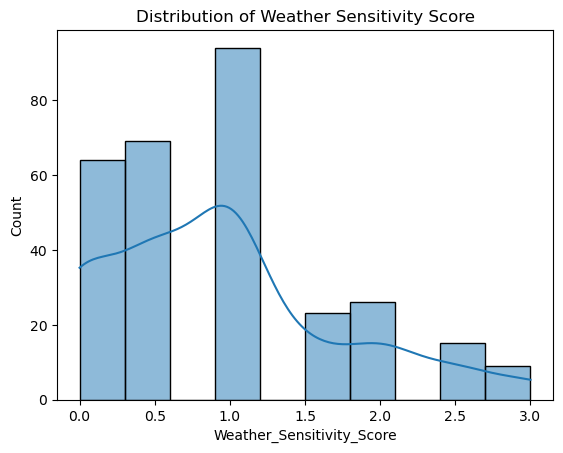

In [11]:
# Summary statistics
print(df.describe())

# Plot distribution of Weather Sensitivity Score
sns.histplot(df['Weather_Sensitivity_Score'], bins=10, kde=True)
plt.title("Distribution of Weather Sensitivity Score")
plt.show()


In [13]:
# Define the target variable
target_column = 'Weather_Sensitivity_Score'
print(f"Target variable: {target_column} — Predicting EV route weather sensitivity scores.")

# Separate features (X) and target (y)
X = df.drop(columns=[target_column])
y = df[target_column]

# Keep only numeric features
X = X.select_dtypes(include=[np.number])

# Show which features we are using
print("\nFeatures used for prediction:")
for col in X.columns:
    print(f" - {col}")

print(f"\nTotal features used: {len(X.columns)}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining samples: {len(X_train)}, Testing samples: {len(X_test)}")

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f" - Mean Squared Error (MSE): {mse:.4f}")
print(f" - R² Score: {r2:.4f}")

# Show a sample of predictions vs actual values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print("\nSample Predictions:")
print(results_df.head(10))


Target variable: Weather_Sensitivity_Score — Predicting EV route weather sensitivity scores.

Features used for prediction:
 - InfrastructureID
 - RatePerHour
 - MaxTime
 - Latitude
 - Longitude
 - TAVG
 - PRCP
 - TMAX
 - TMIN
 - OBJECTID
 - OBJECTID.1
 - Type
 - STYLE
 - MeterNumber
 - MapSymbol
 - Description
 - LifecycleStatus
 - Condition
 - HoursInEffect
 - Length_m
 - Width_m
 - AccessAisle
 - AccessAisleWidth_m
 - LoadingSide
 - DistanceToNearestLetdown_m
 - CrossSlope_percent
 - MeetsSDC16
 - NewSignageInstalled
 - CurbPainted
 - Location
 - CivicAddress
 - Comments
 - Owner
 - OwnerNotes
 - Custodian
 - CustodianNotes
 - geometry
 - geometry.1
 - STATION
 - NAME
 - LATITUDE
 - LONGITUDE
 - ELEVATION
 - DATE
 - PRCP_ATTRIBUTES
 - TAVG_ATTRIBUTES
 - TMAX_ATTRIBUTES
 - TMIN_ATTRIBUTES
 - OBJECTID.2
 - OBJECTID.3
 - Label
 - Direction
 - SHAPE_Length
 - Year
 - PDF
 - geometry.2
 - geometry.3
 - Temp_Range
 - High_Temp_Flag
 - Low_Temp_Flag
 - No_Precip_Flag
 - Temp_Range_Score
 -

In [14]:

df.to_csv("Processed_Combined_Weather_Traffic_EV_with_Score.csv", index=False)
print("Processed dataset saved as Processed_Combined_Weather_Traffic_EV_with_Score.csv")


Processed dataset saved as Processed_Combined_Weather_Traffic_EV_with_Score.csv


In [1]:
DATA_PATH = "Processed_Combined_Weather_Traffic_EV_with_Score.csv"  

# Graph & EV behaviour
K_NEIGHBORS      = 6     # connections per node
EV_RANGE_KM      = 35.0  # max per hop (range constraint)
ASSUMED_SPEED_KMH= 60.0  # used if no speed data available
CHARGE_TIME_MIN  = 15.0  # penalty at intermediate stops (MVP)

# Penalty weights (0..~0.3 reasonable)
ALPHA_WEATHER    = 0.15  # weather impact weight
BETA_TRAFFIC     = 0.10  # traffic impact weight
RANDOM_STATE     = 42

print("Parameters loaded.")

Parameters loaded.


In [2]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, asin, sqrt
import heapq
import matplotlib.pyplot as plt

def load_dataset():
    try:
        df = pd.read_csv(DATA_PATH)
        print(f"Loaded: {DATA_PATH} -> {df.shape}")
        return df
    except Exception as e:
        print(f"Primary load failed: {e}")
        df = pd.read_csv(FALLBACK_DATA_PATH)
        print(f"Loaded fallback: {FALLBACK_DATA_PATH} -> {df.shape}")
        return df

df = load_dataset()
df.head()

Loaded: Processed_Combined_Weather_Traffic_EV_with_Score.csv -> (300, 64)


,InfrastructureID,RatePerHour,MaxTime,Latitude,Longitude,TAVG,PRCP,TMAX,TMIN,OBJECTID,...,PDF,geometry.2,geometry.3,Temp_Range,High_Temp_Flag,Low_Temp_Flag,No_Precip_Flag,Temp_Range_Score,Weather_Sensitivity_Score,Weather_Sensitivity_Score_Norm
0,11,4,-1,48.424600,-123.361093,26.3,0.0,38.4,18.2,19,...,NaN,14,26,20.2,1,0,1,1.0,3.0,0.6
1,18,2,-1,48.446989,-123.334368,20.9,0.0,32.6,19.9,197,...,NaN,8,24,12.7,0,0,1,0.5,0.5,0.1
2,20,2,-1,48.442372,-123.331238,17.3,0.0,21.8,15.3,430,...,NaN,6,81,6.5,0,0,1,0.0,0.0,0.0
3,2,1,2,48.422837,-123.367715,19.6,0.0,22.9,14.5,529,...,NaN,23,93,8.4,0,0,1,0.0,0.0,0.0
4,7,1,1,48.429492,-123.368619,22.2,0.0,30.1,15.8,778,...,NaN,27,91,14.3,0,0,1,0.5,0.5,0.1


## Resolve columns & ensure signals

In [4]:
def pick(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

ID_COL  = pick(df, ["InfrastructureID","SiteID","StationID","ID","id"])
LAT_COL = pick(df, ["Latitude","lat","LAT","Lat"])
LON_COL = pick(df, ["Longitude","lon","LON","Long","Lng"])

if not LAT_COL or not LON_COL:
    raise ValueError("Latitude/Longitude columns not found.")

def to_num(s):
    return pd.to_numeric(s, errors="coerce")

# ---------- Ensure Weather_Sensitivity_Score exists (or compute) ----------
if "Weather_Sensitivity_Score" not in df.columns:
    for c in ["TMAX","TMIN","PRCP"]:
        if c not in df.columns:
            df[c] = 0.0
    df["TMAX"] = to_num(df["TMAX"])
    df["TMIN"] = to_num(df["TMIN"])
    df["PRCP"] = to_num(df["PRCP"])
    df["Temp_Range"] = to_num(df.get("Temp_Range", df["TMAX"] - df["TMIN"]))
    df["High_Temp_Flag"] = (df["TMAX"] > 35).astype(int)
    df["Low_Temp_Flag"]  = (df["TMIN"] < 5).astype(int)
    df["No_Precip_Flag"] = (df["PRCP"] == 0).astype(int)

    def temp_range_score(x):
        if pd.isna(x): return 0.5
        if x > 20: return 1.0
        if x < 10: return 0.0
        return 0.5

    df["Temp_Range_Score"] = df["Temp_Range"].apply(temp_range_score)
    df["Weather_Sensitivity_Score"] = (
        2.0*df["High_Temp_Flag"] +
        1.5*df["Low_Temp_Flag"] +
        (1 - df["No_Precip_Flag"]) +
        df["Temp_Range_Score"]
    )

# Normalise weather score to 0..1
df["Weather_Score_Norm"] = np.clip(to_num(df["Weather_Sensitivity_Score"]) / 5.0, 0, 1)

# ---------- Build a robust Traffic_Proxy ----------
def build_traffic_proxy(df):
    # 1) Use Congestion_Factor if present
    if "Congestion_Factor" in df.columns:
        tp = to_num(df["Congestion_Factor"])
        return tp

    # 2) If both Traffic_Volume and Traffic_Length exist, compute volume per km
    has_vol = "Traffic_Volume" in df.columns
    has_len = "Traffic_Length" in df.columns
    if has_vol and has_len:
        vol = to_num(df["Traffic_Volume"])
        seg = to_num(df["Traffic_Length"])
        # Avoid division by zero or NaN length
        seg_safe = seg.copy()
        seg_safe = seg_safe.replace(0, np.nan)  # works because seg_safe is a Series
        tp = vol / seg_safe
        return tp

    # 3) If speed exists, invert as a congestion proxy (slower -> higher proxy)
    for spd_col in ["AverageSpeed","avg_speed","Speed","speed"]:
        if spd_col in df.columns:
            spd = to_num(df[spd_col])
            # Lower speed => higher proxy; avoid division by zero
            proxy = 1.0 / np.clip(spd, 1e-6, None)
            return proxy

    # 4) Fallback: zeros
    return pd.Series(0.0, index=df.index)

# Only build if not already provided
if "Traffic_Proxy" not in df.columns:
    df["Traffic_Proxy"] = build_traffic_proxy(df)

# Min-max normalise traffic proxy safely (all NaN or constant -> 0)
tp = to_num(df["Traffic_Proxy"])
tp_min = np.nanmin(tp) if np.isfinite(np.nanmin(tp)) else 0.0
tp_max = np.nanmax(tp) if np.isfinite(np.nanmax(tp)) else 0.0
den = (tp_max - tp_min)
if not np.isfinite(den) or den == 0:
    df["Traffic_Proxy_Norm"] = 0.0
else:
    df["Traffic_Proxy_Norm"] = (tp - tp_min) / den

print("Resolved columns:")
print(" ID:", ID_COL, " LAT:", LAT_COL, " LON:", LON_COL)
display(df[[ID_COL, LAT_COL, LON_COL, "Weather_Score_Norm", "Traffic_Proxy_Norm"]].head())


Resolved columns:
 ID: InfrastructureID  LAT: Latitude  LON: Longitude


,InfrastructureID,Latitude,Longitude,Weather_Score_Norm,Traffic_Proxy_Norm
0,11,48.424600,-123.361093,0.6,0.0
1,18,48.446989,-123.334368,0.1,0.0
2,20,48.442372,-123.331238,0.0,0.0
3,2,48.422837,-123.367715,0.0,0.0
4,7,48.429492,-123.368619,0.1,0.0


## Build charger nodes

In [5]:
nodes = df[[ID_COL, LAT_COL, LON_COL, "Weather_Score_Norm", "Traffic_Proxy_Norm"]].dropna().copy()
nodes = nodes.drop_duplicates(subset=[ID_COL]).reset_index(drop=True)
nodes.rename(columns={ID_COL:"node_id", LAT_COL:"lat", LON_COL:"lon"}, inplace=True)
print(nodes.shape)
nodes.head(3)

(28, 5)


,node_id,lat,lon,Weather_Score_Norm,Traffic_Proxy_Norm
0,11,48.424600,-123.361093,0.6,0.0
1,18,48.446989,-123.334368,0.1,0.0
2,20,48.442372,-123.331238,0.0,0.0


## Build edges (k-nearest) with range constraint

In [6]:
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0088
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

coords = nodes[["lat","lon"]].to_numpy()
edges = []
for i, (la, lo) in enumerate(coords):
    d = haversine_km(la, lo, coords[:,0], coords[:,1])
    idx = np.argsort(d)[1:K_NEIGHBORS+1]  # skip self
    for j in idx:
        dist_km = float(d[j])
        if dist_km <= EV_RANGE_KM:   # enforce range
            edges.append((i, j, dist_km))

edges_df = pd.DataFrame(edges, columns=["src","dst","dist_km"])
print(edges_df.shape)
edges_df.head(5)

(168, 3)


,src,dst,dist_km
0,0,22,0.106897
1,0,17,0.119526
2,0,19,0.152060
3,0,27,0.203841
4,0,12,0.210544


## Compute edge costs (weather + traffic adjustments)

In [7]:

def base_time_minutes(dist_km, speed_kmh=ASSUMED_SPEED_KMH):
    return 60.0 * dist_km / max(speed_kmh, 1e-6)

edge_costs = edges_df.copy()
edge_costs["travel_min"] = edge_costs["dist_km"].apply(base_time_minutes)

edge_costs["weather_penalty"] = nodes.loc[edge_costs["dst"], "Weather_Score_Norm"].values * ALPHA_WEATHER
edge_costs["traffic_penalty"] = nodes.loc[edge_costs["dst"], "Traffic_Proxy_Norm"].values * BETA_TRAFFIC

edge_costs["cost_min"] = edge_costs["travel_min"] * (1 + edge_costs["weather_penalty"] + edge_costs["traffic_penalty"])
edge_costs.head(5)

,src,dst,dist_km,travel_min,weather_penalty,traffic_penalty,cost_min
0,0,22,0.106897,0.106897,0.075,0.0,0.114914
1,0,17,0.119526,0.119526,0.000,0.0,0.119526
2,0,19,0.152060,0.152060,0.015,0.0,0.154341
3,0,27,0.203841,0.203841,0.030,0.0,0.209956
4,0,12,0.210544,0.210544,0.075,0.0,0.226335


## Routing: Dijkstra (adds charge penalty at intermediate stops)

In [8]:

from collections import defaultdict

adj = defaultdict(list)
for _, r in edge_costs.iterrows():
    adj[int(r["src"])] .append((int(r["dst"]), float(r["cost_min"]), float(r["dist_km"])))

def dijkstra_with_stop_penalty(start_idx, goal_idx, charge_penalty_min=CHARGE_TIME_MIN):
    N = len(nodes)
    dist = [float('inf')]*N
    prev = [-1]*N
    dist[start_idx] = 0.0
    pq = [(0.0, start_idx)]
    visited = set()
    while pq:
        cur_cost, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)
        if u == goal_idx:
            break
        for v, edge_cost, _ in adj[u]:
            add = charge_penalty_min if v != goal_idx else 0.0
            new_cost = cur_cost + edge_cost + add
            if new_cost < dist[v]:
                dist[v] = new_cost
                prev[v] = u
                heapq.heappush(pq, (new_cost, v))
    if dist[goal_idx] == float('inf'):
        return None, float('inf')
    path = []
    x = goal_idx
    while x != -1:
        path.append(x)
        x = prev[x]
    return path[::-1], dist[goal_idx]

print("Routing functions ready.")

Routing functions ready.


## Pick start/goal and compute route

In [10]:
def nearest_node_idx(lat, lon):
    d = haversine_km(lat, lon, nodes["lat"].to_numpy(), nodes["lon"].to_numpy())
    return int(np.argmin(d))

start_idx = 0
goal_idx  = min(50, len(nodes)-1)

path, total_cost_min = dijkstra_with_stop_penalty(start_idx, goal_idx)
print("Path:", path)
print(f"Total route cost (min): {total_cost_min:.1f}")

Path: [0, 27]
Total route cost (min): 0.2


## Route summary & export

In [11]:
def summarize_path(path_idx):
    if not path_idx:
        return pd.DataFrame()
    rows = []
    for i, n in enumerate(path_idx):
        rows.append({
            "step": i,
            "node_index": int(n),
            "node_id": nodes.loc[n, "node_id"] if "node_id" in nodes.columns else n,
            "lat": float(nodes.loc[n,"lat"]),
            "lon": float(nodes.loc[n,"lon"]),
            "weather_norm": float(nodes.loc[n,"Weather_Score_Norm"]),
            "traffic_norm": float(nodes.loc[n,"Traffic_Proxy_Norm"]),
        })
    return pd.DataFrame(rows)

route_df = summarize_path(path)
route_df.to_csv("Route_Output_Sprint3.csv", index=False)
route_df.head()

,step,node_index,node_id,lat,lon,weather_norm,traffic_norm
0,0,0,11,48.424600,-123.361093,0.6,0.0
1,1,27,1,48.425724,-123.363275,0.2,0.0


## Quick plot (charger nodes + route)

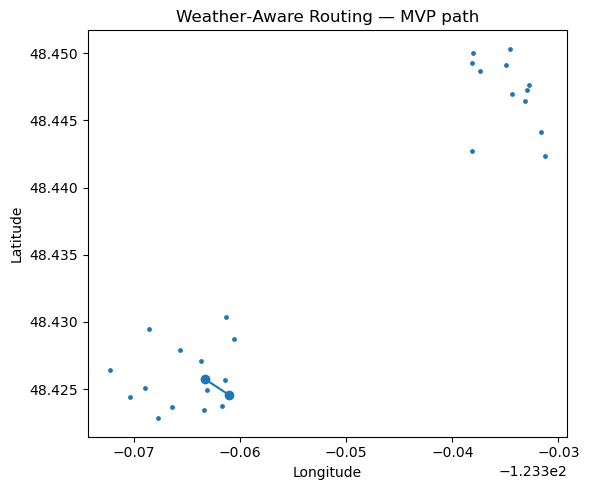

In [12]:

if len(route_df) > 0:
    plt.figure(figsize=(6,5))
    plt.scatter(nodes["lon"], nodes["lat"], s=6)
    plt.plot(route_df["lon"], route_df["lat"], marker='o')
    plt.title("Weather‑Aware Routing — MVP path")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()
else:
    print("No feasible path found. Consider increasing EV_RANGE_KM or K_NEIGHBORS.")

## Sensitivity sandbox

In [13]:
print(f"EV_RANGE_KM={EV_RANGE_KM}, K_NEIGHBORS={K_NEIGHBORS}, ALPHA_WEATHER={ALPHA_WEATHER}, BETA_TRAFFIC={BETA_TRAFFIC}, CHARGE_TIME_MIN={CHARGE_TIME_MIN}")
print(f"Total route cost (min): {total_cost_min:.1f}")
print(f"Route steps: {len(path) if path else 0}")

EV_RANGE_KM=35.0, K_NEIGHBORS=6, ALPHA_WEATHER=0.15, BETA_TRAFFIC=0.1, CHARGE_TIME_MIN=15.0
Total route cost (min): 0.2
Route steps: 2
